In [1]:
import torch
import torch_geometric_temporal
import json
import numpy as np
from torch_geometric_temporal.signal import StaticGraphTemporalSignal
import os
import pandas as pd
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(0)
torch.manual_seed(0)

In [2]:
directory = 'Dataset/'


# get station ids with their latitude and longitude to calculate their distances
# opening excel file
filename = 'station_id.xlsx'
stations = pd.read_excel(os.path.join(directory, filename))
stations.describe

<bound method NDFrame.describe of       id   Latitude  Longitude
0      1  35.702270  51.350940
1      5  35.695990  51.493760
2      6  35.795870  51.484140
3      7  35.762300  51.331680
4      8  35.777089  51.368175
5      9  35.731030  51.506130
6     10  35.630030  51.499020
7     11  35.741820  51.506430
8     12  35.603630  51.425710
9     14  35.727080  51.431200
10    15  35.644584  51.397657
11    16  35.697480  51.358030
12    17  35.672980  51.389730
13    18  35.635210  51.362520
14    19  35.697773  51.243110
15    20  35.678820  51.337530
16    21  35.661083  51.466360
17    22  35.670050  51.297350
18    41  35.717510  51.385909
19    45  35.778232  51.428623
20    49  35.723398  51.243640
21  1000   0.000000   0.000000>

In [3]:
import haversine as hs

distances = dict()

id_map = dict()

for i in range(len(stations)):
    id_map[i] = stations.iloc[i, 0]
    for j in range(i+1, len(stations)):
        id1 = i
        id2 = j
        lat1 = stations.iloc[i, 1]
        lon1 = stations.iloc[i, 2]
        lat2 = stations.iloc[j, 1]
        lon2 = stations.iloc[j, 2]
        distances[(id1, id2)] = hs.haversine((lat1, lon1), (lat2, lon2))
        

In [4]:
# min, max, average distances
min_dist = min(distances.values())
max_dist = max(distances.values())
avg_dist = sum(distances.values()) / len(distances.values())

print("Minimum distance between two stations: ", min_dist)
print("Maximum distance between two stations: ", max_dist)
print("Average distance between two stations: ", avg_dist)


Minimum distance between two stations:  0.8328132420953865
Maximum distance between two stations:  6634.11423138168
Average distance between two stations:  612.9518111656231


In [5]:
threshold = 8

edges = [[], []]
edge_weight = []

couter = 0
for (id1, id2), value in distances.items():
    if value < threshold:
        edges[0].append(id1)
        edges[1].append(id2)

        edge_weight.append(1/value)
        # print(f'({id1}, {id2}):', value)
        couter += 1
print(couter)

58


In [6]:
# edges discribe

edges = torch.tensor(edges)
edge_weight = torch.tensor(edge_weight)

print(edges.shape)
print(edge_weight.shape)

torch.Size([2, 58])
torch.Size([58])


In [7]:
# define the number of features
feature_num = 1

# define the number of time steps
time_step = 5

In [8]:
filename = 'AQIData_weather_filled_index.xlsx'
all_data = pd.read_excel(os.path.join(directory, filename))

In [9]:
# iterate over column of all_data with PM2_5_{station_id} format
# and create a dictionary with key as station_id and value as the column

station_data = []
used_id = []
for col in all_data:
    if col.startswith('PM2_5'):
        station_id = int(col.split('_S')[1])
        if station_id in stations['id'].values:
            used_id.append(station_id)
            x = all_data[col].to_numpy()
            station_data.append(x)

# convert station_data to numpy array
station_data = np.array(station_data)
# len(used_id)

In [10]:
# check nan values
np.isnan(station_data).sum()

0

In [11]:
station_data = torch.tensor(station_data)

station_data.shape

torch.Size([21, 2543])

In [12]:
node_num, _ = station_data.shape

node_num

21

In [13]:
# mean, max, average of features

print('PM2.5', station_data[:, :].mean(), station_data[:, :].max(), station_data[:, :].min())

PM2.5 tensor(87.1957, dtype=torch.float64) tensor(500., dtype=torch.float64) tensor(-210.8313, dtype=torch.float64)


In [14]:
# normalize data based on z score in torch geometric temporal
import torch
import torch.nn.functional as F

# define the normalization
normalized_dataset = np.array(F.normalize(station_data, dim=1))

In [15]:
dataset = np.array(station_data)

In [16]:
print(dataset[0][0])
print(normalized_dataset[0][0])

98.48333333333333
0.019088528638411234


In [17]:
print(dataset.shape)
print(normalized_dataset.shape)

(21, 2543)
(21, 2543)


In [18]:
# print shapes
print(normalized_dataset.shape)
print(edges.shape)
print(edge_weight.shape)

(21, 2543)
torch.Size([2, 58])
torch.Size([58])


In [19]:
time_step = 4

# targets are in dataset after timestep
features_pm2_5 = []
n_features_pm2_5 = [] # normalized

target_pm2_5 = []
n_target_pm2_5 = [] # normalized

for i in range(dataset.shape[1] - time_step):
    features_pm2_5.append(np.array(dataset[:, i:i + time_step]))
    n_features_pm2_5.append(np.array(normalized_dataset[:, i:i + time_step]))

    target_pm2_5.append(np.array(dataset[:, i + time_step]))
    n_target_pm2_5.append(np.array(normalized_dataset[:, i + time_step]))

In [20]:
features_pm2_5 = np.array(features_pm2_5)
n_features_pm2_5 = np.array(n_features_pm2_5)

target_pm2_5 = np.array(target_pm2_5)
n_target_pm2_5 = np.array(n_target_pm2_5)

In [21]:
print('feature shape:', features_pm2_5.shape)
print('target shape:', target_pm2_5.shape)

feature shape: (2539, 21, 4)
target shape: (2539, 21)


In [22]:
# max, min, average of CO targets

print('before normalize:', target_pm2_5.max(), target_pm2_5.min(), target_pm2_5.mean())
print('after normalize:', n_target_pm2_5.max(), n_target_pm2_5.min(), n_target_pm2_5.mean())

before normalize: 500.0 -210.8313208995429 87.16893771476327
after normalize: 0.12784367042059902 -0.02294477657580848 0.018733973406288087


In [23]:
spatio = StaticGraphTemporalSignal(
    edges,
    edge_weight,
    n_features_pm2_5,
    n_target_pm2_5,
)

spatio

In [24]:
# batch iterator
from torch_geometric_temporal import StaticGraphTemporalSignalBatch

batch_size = 32
# spatio_loader = StaticGraphTemporalSignalBatch(edges, edge_weight, features_pm2_5, target_pm2_5, batch_size)
spatio_loader = StaticGraphTemporalSignalBatch(edges, edge_weight, n_features_pm2_5, n_target_pm2_5, batch_size )


In [25]:
spatio_loader

In [26]:
from torch_geometric_temporal.signal import temporal_signal_split

train_dataset, test_dataset = temporal_signal_split(spatio_loader, train_ratio=0.7)

In [27]:
for i in train_dataset:
    print(i)
    break

DataBatch(x=[21, 4], edge_index=[2, 58], edge_attr=[58], y=[21], batch=[32])


In [28]:
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import DCRNN
from torch_geometric_temporal import GConvGRU

class RecurrentGCN(torch.nn.Module):
    def __init__(self, time_step):
        super(RecurrentGCN, self).__init__()
        self.recurrent = GConvGRU(time_step, 32, 8)
        self.linear = torch.nn.Linear(32, 1)

    def forward(self, x, edge_index, edge_weight):
        # print(x.shape)
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h

In [29]:
# from torch_geometric.nn import GCNConv, TransformerConv

# feature_num = 1

# # Define your model architecture:
# class GCNTransformer(torch.nn.Module):
#     weight =[]
#     def __init__(self, time_step, feature_num):
#         super(GCNTransformer, self).__init__()
#         self.gcn1 = GCNConv(feature_num * time_step, 6 * time_step)
#         self.gcn2 = GCNConv(6 * time_step, 6 * time_step)
#         # self.gcn3 = GCNConv(12 * time_step, 6 * time_step)
#         self.transformer1 = TransformerConv(6 * time_step, 1, heads= 3 * time_step, dropout=0.3)
#         self.transformer2 = TransformerConv(3 * time_step, 1, heads= 1, dropout=0.3)
#         # self.transformer3 = TransformerConv(3, 1, heads= 1, dropout=0.3)

#     def forward(self, x, edge_index, edge_weight):
 
#         x = self.gcn1(x, edge_index, edge_weight)
#         x = F.relu(x)
#         # x = x.view(-1, x.size(-1))

#         x = self.gcn2(x, edge_index, edge_weight)
#         # # x = self.gcn3(x, edge_index)
#         x = F.relu(x)

#         # x = self.gcn3(x, edge_index)
#         # x = F.relu(x)

#         x = self.transformer1(x, edge_index)
#         x = F.relu(x)
#         # combine res1 and res2, with size
#         # size: 2*feature and 2*feature 
#         # x = torch.cat((res1, res2), 1)

#         x = self.transformer2(x, edge_index)
#         # x = F.relu(x)

#         # x = self.transformer3(x, edge_index)

#         return x

    
# # Instantiate your model:
# # model = MyModel(gcn1, gcn2, gcn3, transformer1, transformer2)



In [30]:
# from torch_geometric_temporal import GConvGRU
# model = GConvGRU(3, 1, 5)

In [31]:
# from tqdm import tqdm

# model = RecurrentGCN(node_features = time_step)


# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# model.train()
# losses = []
# for epoch in tqdm(range(150)):
#     cost = 0
#     for time, snapshot in enumerate(train_dataset):
#         y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
#         cost = cost + torch.mean((y_hat-snapshot.y)**2)
#     cost = cost / (time+1)
#     losses.append(cost.detach().numpy())
#     cost.backward()
#     optimizer.step()
#     optimizer.zero_grad()

In [32]:
# model.eval()
# loss_test = []
# cost = 0
# for time, snapshot in enumerate(test_dataset):
#     y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
#     c = torch.mean((y_hat-snapshot.y)**2)
#     loss_test.append(c.detach().numpy())
#     cost = cost + c
# cost = cost / (time+1)
# cost = cost.item()
# print("MSE: {:.4f}".format(cost))

In [69]:
# train over train_datset batches
from torch.optim import Adam
from tqdm import tqdm

model = RecurrentGCN(time_step)
# model = GCNTransformer(time_step, feature_num)

optimizer = Adam(model.parameters(), lr=0.0005)
model.train()

epoch_num = 150

losses = [[] for i in range(epoch_num)]

y_pred = [[] for i in range(epoch_num)]

for epoch in tqdm(range(epoch_num)):    
    for i, batch in enumerate(train_dataset):
        
        # print(batch.x)
        # print(batch.edge_index)
        # print(batch.edge_attr)

        out = model(batch.x, batch.edge_index, batch.edge_attr)

        y_pred[epoch].append(out)
        loss = F.mse_loss(out, batch.y)

        losses[epoch].append(loss.item())
        loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()
        # if (i+1) % 400 == 0:
        #     print(f'Epoch [{epoch+1}/{epoch_num}], Step [{i+1}], Loss: {loss.item()}')
    
    # print(loss)

  0%|          | 0/100 [00:00<?, ?it/s]/var/folders/h8/mhwh4fjn0qj405sjdd9_5ffw0000gn/T/ipykernel_12176/328521807.py:27: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(out, batch.y)
100%|██████████| 100/100 [20:03<00:00, 12.03s/it]


In [70]:
losses = np.array(losses)

counter = 0
for i in range(losses.shape[0]):
    for j in range(losses.shape[1]):
        if losses[i][j] > 1:
            # print(f'losses[{i}][{j}] =', losses[i][j])
            counter += 1

print('counter =', counter)
losses.shape

counter = 0


(100, 1777)

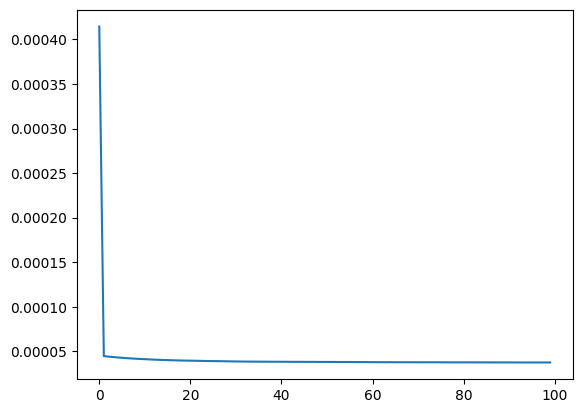

In [71]:
mean_loss = np.mean(losses, axis=1)

plt.plot(mean_loss)

In [72]:
model.eval()
loss_test = []
y_pred_test = []
y_true_test = []
cost = 0
for time, snapshot in enumerate(test_dataset):
    y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
    
    y_pred_test.append(y_hat.detach().numpy())
    y_true_test.append(snapshot.y.detach().numpy())

    c = F.mse_loss(y_hat, snapshot.y)
    loss_test.append(c.detach().numpy())
    cost = cost + c
cost = cost / (time+1)
cost = cost.item()
print("MSE: {}".format(cost))

/var/folders/h8/mhwh4fjn0qj405sjdd9_5ffw0000gn/T/ipykernel_12176/1162775844.py:12: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  c = F.mse_loss(y_hat, snapshot.y)


MSE: 4.364907363196835e-05


In [73]:
# plot y_pred and y_true
y_pred_test_mean = np.array(y_pred_test).reshape(-1, node_num).mean(axis=1).flatten()
y_true_test_mean = np.array(y_true_test).reshape(-1, node_num).mean(axis=1).flatten()

print('shape: ', y_pred_test_mean.shape)
print('shape: ', y_true_test_mean.shape)

shape:  (762,)
shape:  (762,)


<AxesSubplot:>

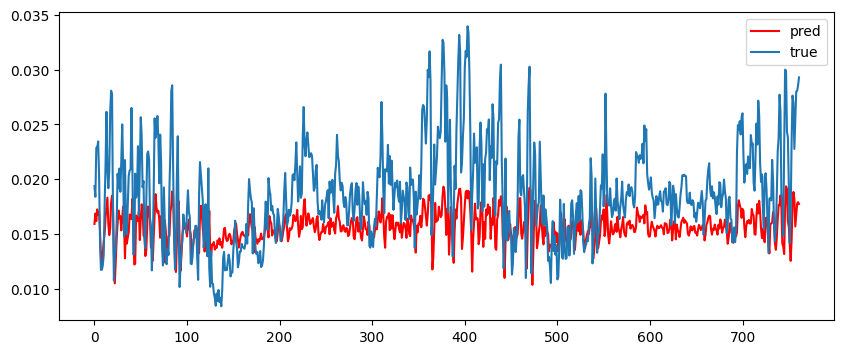

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,4))
sns.lineplot(data=y_pred_test_mean, label="pred", color='red')
sns.lineplot(data=y_true_test_mean, label="true")

In [75]:
# Calc MAPE
y_pred_test = np.array(y_pred_test)
y_true_test = np.array(y_true_test).flatten()


mape = np.mean(np.abs((y_true_test - y_pred_test) / y_true_test)) * 100
print("MAPE: {:.4f}".format(mape))

MAPE: 29.8763


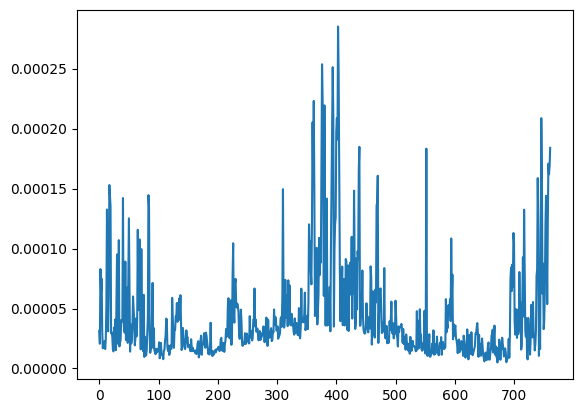

In [76]:
# plot loss
import matplotlib.pyplot as plt
plt.plot(loss_test)

In [77]:
# mean loss in each epoch
losses_mean = [np.mean(i) for i in losses]

for i in range(epoch_num):
    print(f'epoch [{i}/{epoch_num}] :', losses_mean[i])


epoch [0/100] : 0.0004145030109908321
epoch [1/100] : 4.467296442237838e-05
epoch [2/100] : 4.41004774994046e-05
epoch [3/100] : 4.359773519119937e-05
epoch [4/100] : 4.3106958751249375e-05
epoch [5/100] : 4.2767619320025154e-05
epoch [6/100] : 4.235298536718379e-05
epoch [7/100] : 4.2026066003796016e-05
epoch [8/100] : 4.1704793839006695e-05
epoch [9/100] : 4.14459210498323e-05
epoch [10/100] : 4.121031916110746e-05
epoch [11/100] : 4.0939927435234576e-05
epoch [12/100] : 4.070412700642659e-05
epoch [13/100] : 4.049236466947728e-05
epoch [14/100] : 4.0301398013205475e-05
epoch [15/100] : 4.0141625507929836e-05
epoch [16/100] : 3.998319251241361e-05
epoch [17/100] : 3.983905795091099e-05
epoch [18/100] : 3.970806544236567e-05
epoch [19/100] : 3.959543217940316e-05
epoch [20/100] : 3.9507081638702674e-05
epoch [21/100] : 3.941604495530243e-05
epoch [22/100] : 3.931226606751683e-05
epoch [23/100] : 3.920591743047322e-05
epoch [24/100] : 3.9117882924722834e-05
epoch [25/100] : 3.905650876